En este notebook vamos a armar y entrenar los primeros modelos en base al set creado en EDA.ipynb

In [1]:
from src import metrics
from src import plots

import pandas as pd
import numpy as np

In [2]:
TRAIN_PATH = "data/processed/monaco_2025_colapinto_train.csv"
TEST_PATH  = "data/processed/monaco_2025_colapinto_test.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print(train_df.shape, test_df.shape)
train_df.head()


(74, 33) (35, 33)


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTime_s,Session
0,0 days 00:20:13.553000,COL,43,0 days 00:01:21.554000,2.0,1.0,NaN,NaN,0 days 00:00:21.906000,0 days 00:00:38.005000,...,0 days 00:18:51.999000,2025-05-23 11:33:52.006,1,NaN,False,NaN,False,True,81.554,FP1
1,0 days 00:21:31.817000,COL,43,0 days 00:01:18.264000,3.0,1.0,NaN,NaN,0 days 00:00:20.706000,0 days 00:00:36.862000,...,0 days 00:20:13.553000,2025-05-23 11:35:13.560,1,NaN,False,NaN,False,True,78.264,FP1
2,0 days 00:32:59.095000,COL,43,0 days 00:01:17.385000,7.0,2.0,NaN,NaN,0 days 00:00:20.513000,0 days 00:00:36.473000,...,0 days 00:31:41.710000,2025-05-23 11:46:41.717,1,NaN,False,NaN,False,True,77.385,FP1
3,0 days 00:35:56.644000,COL,43,0 days 00:01:16.777000,9.0,2.0,NaN,NaN,0 days 00:00:20.280000,0 days 00:00:35.999000,...,0 days 00:34:39.867000,2025-05-23 11:49:39.874,1,NaN,False,NaN,False,True,76.777,FP1
4,0 days 00:38:50.930000,COL,43,0 days 00:01:15.875000,11.0,2.0,NaN,NaN,0 days 00:00:20.053000,0 days 00:00:35.723000,...,0 days 00:37:35.055000,2025-05-23 11:52:35.062,1,NaN,False,NaN,False,True,75.875,FP1


Asegurarnos de tener LapTime_s como target numérico

In [3]:
def ensure_laptime_seconds(df):
    df = df.copy()
    if "LapTime_s" in df.columns:
        # Ya está listo
        return df
    
    if "LapTime" not in df.columns:
        raise ValueError("No encuentro LapTime ni LapTime_s en el dataframe.")
    
    # Convertir LapTime a timedelta si hiciera falta
    if not np.issubdtype(df["LapTime"].dtype, np.number):
        df["LapTime"] = pd.to_timedelta(df["LapTime"])
    
    df["LapTime_s"] = df["LapTime"].dt.total_seconds()
    return df

train_df = ensure_laptime_seconds(train_df)
test_df  = ensure_laptime_seconds(test_df)

train_df[["LapTime", "LapTime_s"]].head()


,LapTime,LapTime_s
0,0 days 00:01:21.554000,81.554
1,0 days 00:01:18.264000,78.264
2,0 days 00:01:17.385000,77.385
3,0 days 00:01:16.777000,76.777
4,0 days 00:01:15.875000,75.875


Definir las columnas “legales” para X

In [4]:
LEGAL_FEATURES = [
    "LapNumber",
    "Stint",
    "TyreLife",
    "Position",
    "Session",
    "Compound",
    "FreshTyre",
]

LEGAL_FEATURES = [c for c in LEGAL_FEATURES if c in train_df.columns]

print("Features legales que voy a usar:")
print(LEGAL_FEATURES)


Features legales que voy a usar:
['LapNumber', 'Stint', 'TyreLife', 'Position', 'Session', 'Compound', 'FreshTyre']


Me quedo solo con las vueltas con bandera Verde. (Habian quedad algunas con bandera amarilla en algunos sectores)

In [5]:
# Filtrar solo vueltas con pista "normal"
train_df = train_df[train_df["TrackStatus"] == 1].copy()
test_df  = test_df[test_df["TrackStatus"] == 1].copy()

print("TRAIN después de filtrar TrackStatus == 1:", train_df.shape)
print("TEST después de filtrar TrackStatus == 1:", test_df.shape)

print(train_df["TrackStatus"].value_counts(dropna=False))
print(test_df["TrackStatus"].value_counts(dropna=False))


TRAIN después de filtrar TrackStatus == 1: (68, 33)
TEST después de filtrar TrackStatus == 1: (33, 33)
TrackStatus
1    68
Name: count, dtype: int64
TrackStatus
1    33
Name: count, dtype: int64


Construyo X e Y para train y test

In [6]:
y_train = train_df["LapTime_s"].to_numpy()
y_test  = test_df["LapTime_s"].to_numpy()

X_train_raw = train_df[LEGAL_FEATURES].copy()
X_test_raw  = test_df[LEGAL_FEATURES].copy()

X_train_raw.head()


,LapNumber,Stint,TyreLife,Position,Session,Compound,FreshTyre
0,2.0,1.0,2.0,NaN,FP1,HARD,True
1,3.0,1.0,3.0,NaN,FP1,HARD,True
2,7.0,2.0,7.0,NaN,FP1,HARD,False
3,9.0,2.0,9.0,NaN,FP1,HARD,False
4,11.0,2.0,11.0,NaN,FP1,HARD,False


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Si no los tenés definidos en esta notebook, los re-definís:
LEGAL_FEATURES_NUM = ["LapNumber", "Stint", "TyreLife", "Position"]
LEGAL_FEATURES_CAT = ["Session", "Compound"]

# Filtrar solo las que existan por si acaso
LEGAL_FEATURES_NUM = [c for c in LEGAL_FEATURES_NUM if c in X_train_raw.columns]
LEGAL_FEATURES_CAT = [c for c in LEGAL_FEATURES_CAT if c in X_train_raw.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), LEGAL_FEATURES_NUM),
        ("cat", OneHotEncoder(handle_unknown="ignore"), LEGAL_FEATURES_CAT),
    ]
)


In [8]:
# Ajusta scaler + OHE usando SOLO el train
X_train = preprocessor.fit_transform(X_train_raw)

# Usa los parámetros del train para transformar el test
X_test = preprocessor.transform(X_test_raw)

X_train.shape, X_test.shape


((68, 11), (33, 11))

Entrenamiento de Modelos

1) RANDOM FOREST

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", rf),
])

model.fit(X_train_raw, y_train)

y_pred = model.predict(X_test_raw)


In [10]:

y_pred = model.predict(X_test_raw)

print(metrics.regression_report(y_test, y_pred))
print("MAE:", metrics.MAE(y_test, y_pred))
print("RMSE:", metrics.RMSE(y_test, y_pred))
print("R2:", metrics.R2(y_test, y_pred))


{'MAE': 0.9434, 'RMSE': np.float64(1.2913), 'R2': 0.2898}
MAE: 0.9433553535353865
RMSE: 1.2913050276039237
R2: 0.2897784579489314


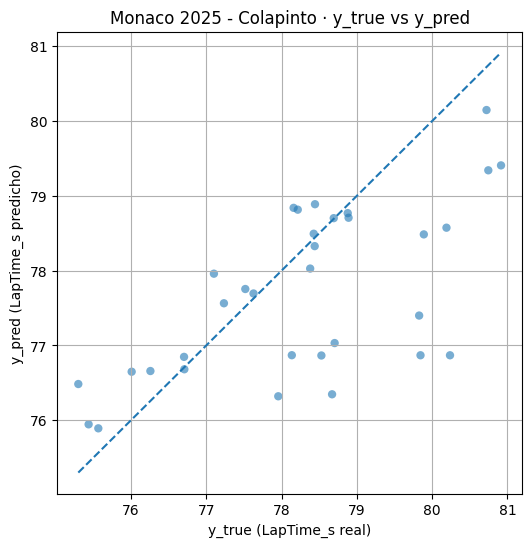

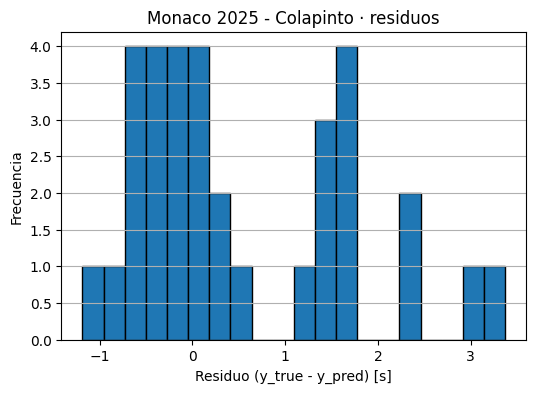

In [11]:


y_pred = model.predict(X_test_raw)

plots.y_true_vs_y_pred(
    y_test,
    y_pred,
    title="Monaco 2025 - Colapinto · y_true vs y_pred"
)

plots.residuals_hist(
    y_test,
    y_pred,
    title="Monaco 2025 - Colapinto · residuos"
)


Las priemras metricas muestran lo siguiente:

MAE ≈ 0.94 s, RMSE ≈ 1.29 s

Tus tiempos están en el rango ~76–81 s, así que el error típico es ~1–1.5% del tiempo de vuelta.

Para “feeling racing”: 1 s por vuelta es mucho para comparar compuestos/estrategias finas (diferencias de 0.2–0.4 s), pero como primer baseline no está mal para haber usado solo features “legales” y un único piloto en un solo circuito.